In [ ]:
# import user defined function
from src.preprocessing import ut_standard_col_name
from src.model_functions import evaluate_classification, cv_bestK
from src.eda_functions import get_info

# import standard processing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import numpy as np

# import sci-kit learn methods
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

RANDOM_SEED = 19

# 1. Exploratory Data Analysis

In this section we are going to explore the dataset.

## 1.1 Summary information

The function `get_info()` creates a `pandas.DataFrame` with useful information for each variable in the dataset.

In particular, the result shows that there are no missing values in the input dataset. Hence, it is not necessary to impute values.

Moreover, the independent variables have different unit of measurement, thus, it is necessary to preprocess the features in order to avoid the case where the model gives more importance to a feature respect to another one due to the magnitude.

## 1.2 Duplicates

The daset does not present duplicated rows. Hence, there is no need to deel with these cases.

## 1.3 Balanced dataset

Another issue in classification problems can be due to unbalanced data in the target. Therefore, the cell below use the function `value_counts()` for the target variable `frutto` and the result shows the dataset is perfectly balanced.

In [69]:
# read data
# input_df = pd.read_csv("https://proai-datasets.s3.eu-west-3.amazonaws.com/fruits.csv")
input_df = pd.read_csv("./data/fruits.csv")

# standardise columns names
input_df = ut_standard_col_name(input_df)

# get initial information of input DataFrame
info_input_df = get_info(input_df)
display(info_input_df)

# check duplicates
print(f"The input dataset has {input_df.duplicated().sum()} duplicates.")

# check unbalanced target
display(input_df.frutto.value_counts())

,dtype,n_unique,nan_values,count,mean,std,min,25%,50%,75%,max
frutto,object,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
peso_(g),float64,470,0,500.0,47.31344,26.768797,8.57,24.7975,42.380,68.0800,111.21
diametro_medio_(mm),float64,487,0,500.0,86.57310,64.293403,7.53,50.5100,70.450,88.8525,299.89
lunghezza_media_(mm),float64,373,0,500.0,5.29862,2.641993,1.15,2.6725,5.670,7.4550,11.14
durezza_buccia_(1-10),float64,349,0,500.0,7.43764,1.812548,3.07,6.1525,7.340,8.6150,13.72
dolcezza_(1-10),float64,305,0,500.0,3.59322,1.264899,1.25,2.5700,3.535,4.4650,6.95


The input dataset has 0 duplicates.


Mela       100
Banana     100
Arancia    100
Uva        100
Kiwi       100
Name: frutto, dtype: int64

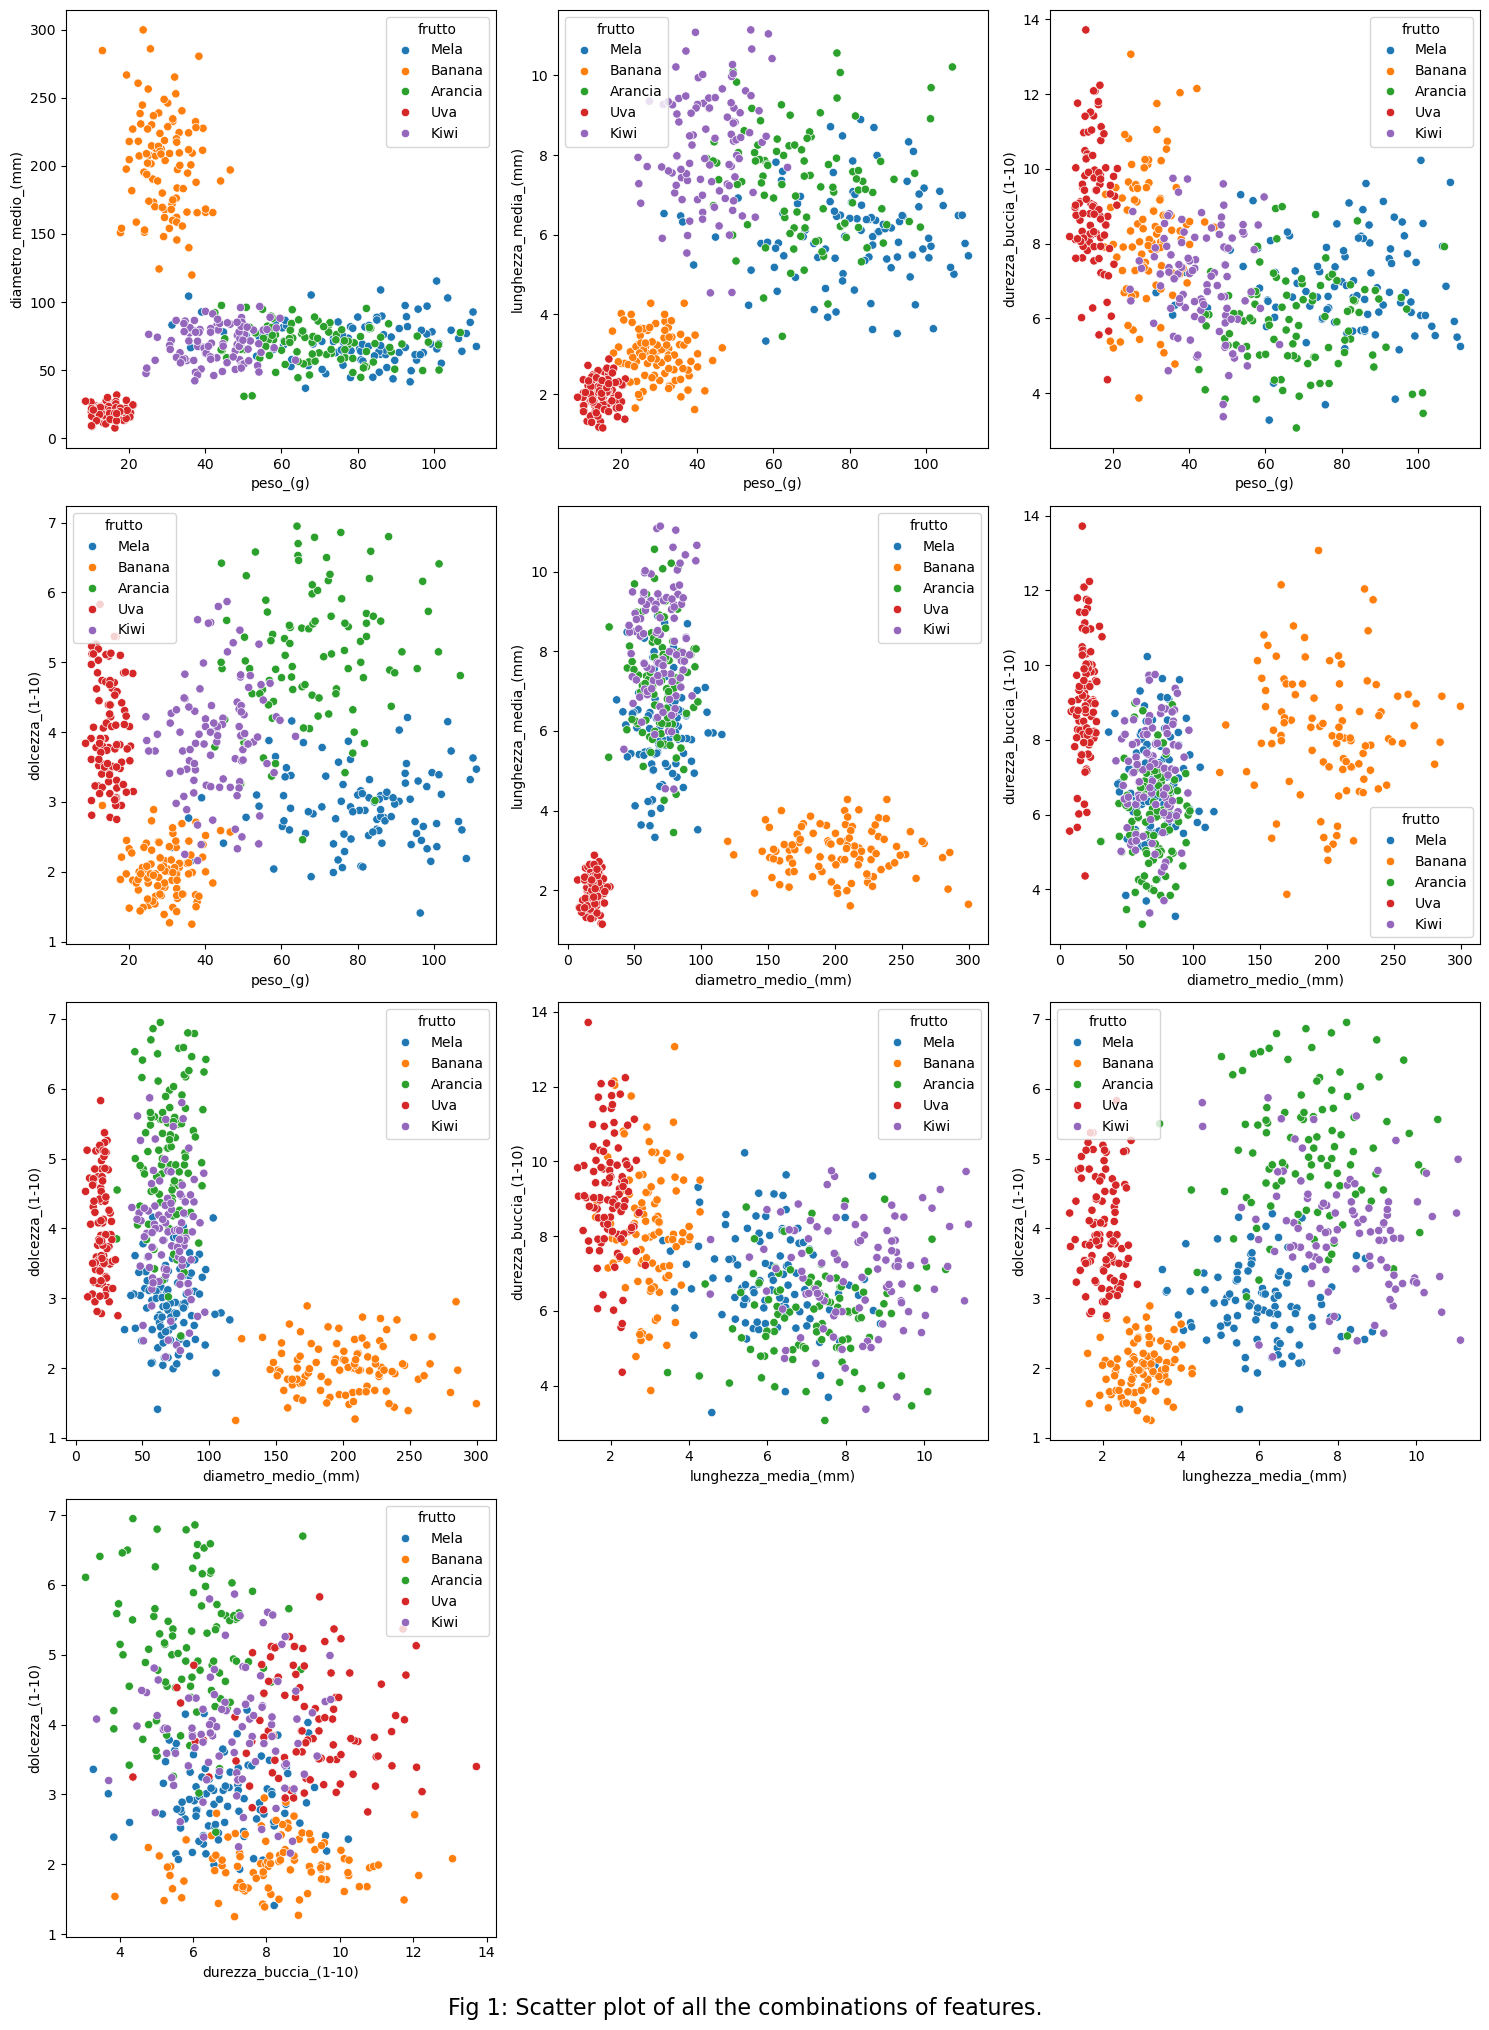

In [74]:
features_ls = list(input_df.columns)
features_ls.remove('frutto')
features_combination_ls = list(combinations(features_ls, r=2))

n_fig_per_row = 3
n_rows = int(np.ceil(len(features_combination_ls)/n_fig_per_row))

fig, axs = plt.subplots(nrows=n_rows,
                        ncols=n_fig_per_row,
                        figsize=(15, 5*n_rows),
                        tight_layout=True)

for (f1, f2), ax in zip(features_combination_ls, axs.ravel()):
    sns.scatterplot(data=input_df, x=f1, y=f2, hue='frutto', ax=ax)

# set axis off
for ax in axs.ravel()[len(features_combination_ls):]:
    ax.set_axis_off()

fig.text(0.5, -0.01, 'Fig 1: Scatter plot of all the combinations of features.', ha='center', fontsize=16)
plt.show()

In [80]:
# dictionary to encode target variable
fruits_dict = {
    'Arancia': 0,
    'Banana': 1,
    'Kiwi': 2,
    'Mela': 3,
    'Uva' : 4
}

X = input_df.drop(columns=['frutto']).values
y = input_df.frutto.map(lambda x: fruits_dict[x]).values

# split dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_SEED)

mms = MinMaxScaler()
X_train_processed = mms.fit_transform(X_train)
X_test_processed = mms.transform(X_test)

In [81]:
# apply cross validation
N_SPLITS = 5
metrics_cv_df = cv_bestK(dataset=(X_train, y_train),
                         Ks=np.arange(1, 45, 1),
                         preprocessor=MinMaxScaler(),
                         n_splits=N_SPLITS,
                         rnd_seed=RANDOM_SEED,
                         all_metrics=True)

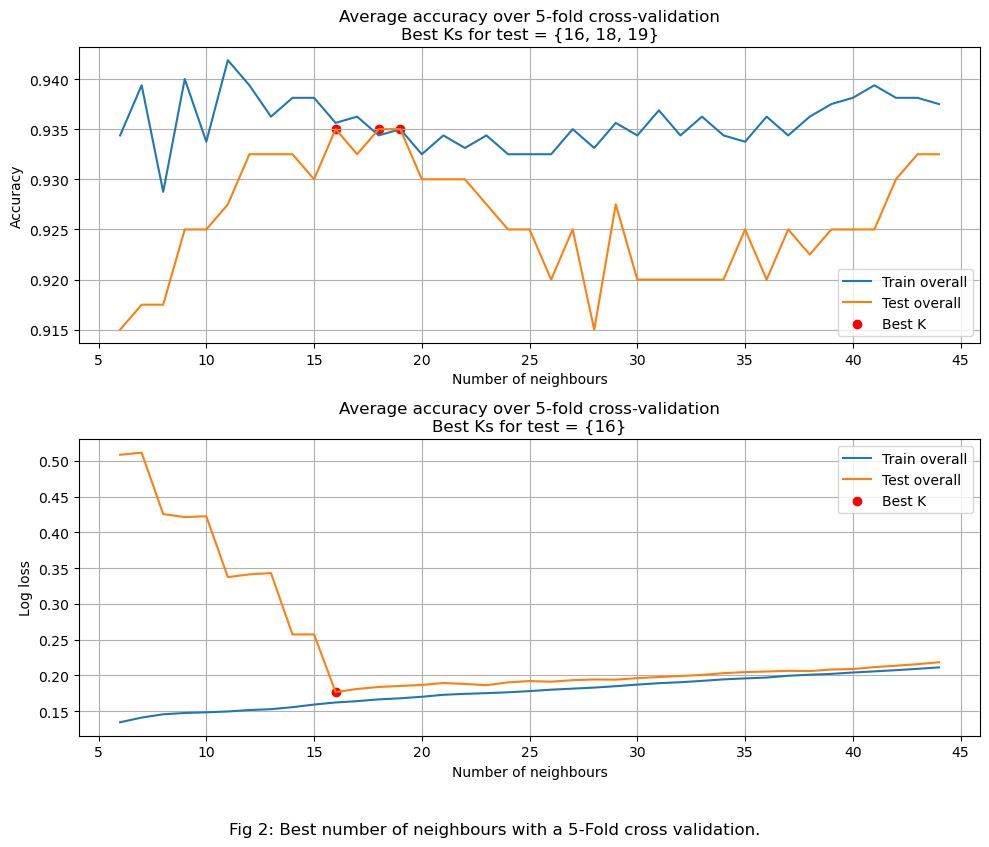

In [83]:
min_neighbours = 5

best_test_accuracy = metrics_cv_df.loc[min_neighbours:, 'test_accuracy_overall'].max()
best_k_accuracy = set(metrics_cv_df.loc[metrics_cv_df.test_accuracy_overall==best_test_accuracy, 'n_neighbours'].to_list())
best_test_loss = metrics_cv_df.loc[min_neighbours:, 'test_loss_overall'].min()
best_k_loss = set(metrics_cv_df.loc[metrics_cv_df.test_loss_overall==best_test_loss, 'n_neighbours'].to_list())


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 4*2), tight_layout=True)
ax1.plot(metrics_cv_df.loc[min_neighbours:, 'n_neighbours'],
             metrics_cv_df.loc[min_neighbours:, 'train_accuracy_overall'],
             label=f"Train overall")
ax1.plot(metrics_cv_df.loc[min_neighbours:, 'n_neighbours'],
             metrics_cv_df.loc[min_neighbours:, 'test_accuracy_overall'],
             label=f"Test overall")
ax1.scatter(list(best_k_accuracy),
            [best_test_accuracy]*len(list(best_k_accuracy)),
            color='red',
            label="Best K")
ax1.legend()
ax1.grid()
ax1.set(title=f"Average accuracy over {N_SPLITS}-fold cross-validation\nBest Ks for test = {best_k_accuracy}",
        xlabel="Number of neighbours",
        ylabel="Accuracy")

ax2.plot(metrics_cv_df.loc[min_neighbours:, 'n_neighbours'],
             metrics_cv_df.loc[min_neighbours:, 'train_loss_overall'],
             label=f"Train overall")
ax2.plot(metrics_cv_df.loc[min_neighbours:, 'n_neighbours'],
             metrics_cv_df.loc[min_neighbours:, 'test_loss_overall'],
             label=f"Test overall")
ax2.scatter(list(best_k_loss),
            [best_test_loss]*len(list(best_k_loss)),
            color='red',
            label="Best K")
ax2.legend()
ax2.grid()
ax2.set(title=f"Average accuracy over {N_SPLITS}-fold cross-validation\nBest Ks for test = {best_k_loss}",
        xlabel="Number of neighbours",
        ylabel="Log loss")

fig.text(0.5, -0.05, f'Fig 2: Best number of neighbours with a {N_SPLITS}-Fold cross validation.', ha='center', fontsize=12)
plt.show()

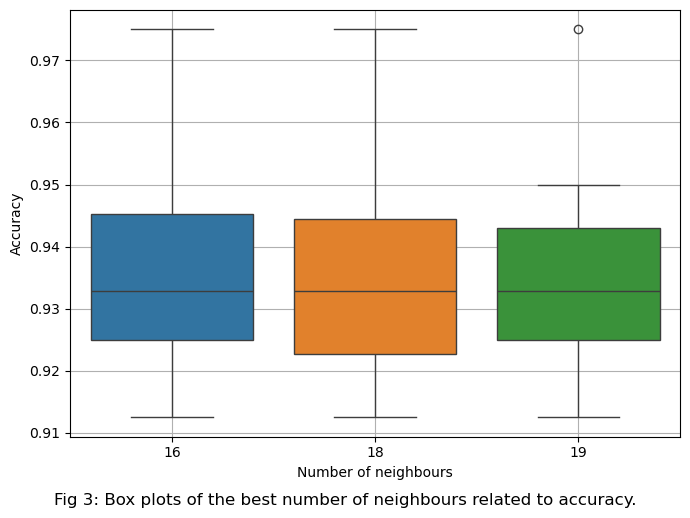

In [ ]:
# Drop overall information
columns_to_drop = ["train_accuracy_overall", "train_loss_overall",
                   "test_accuracy_overall", "test_loss_overall"]
best_accuracy_folds_df = metrics_cv_df.drop(columns=columns_to_drop)

# get metrics related to Ks with best accuracy
best_accuracy_folds_df = best_accuracy_folds_df[best_accuracy_folds_df.n_neighbours.isin(list(best_k_accuracy))]
best_accuracy_folds_df = best_accuracy_folds_df.set_index("n_neighbours").T
best_accuracy_folds_df = best_accuracy_folds_df[best_accuracy_folds_df.index.str.contains('accuracy')]

# Show box plots
fig, ax = plt.subplots(1,1, figsize=(7, 5), tight_layout=True)
sns.boxplot(best_accuracy_folds_df, ax=ax, zorder=2)
ax.set(xlabel="Number of neighbours",
       ylabel="Accuracy")
ax.grid()
fig.text(0.5, -0.02, f'Fig 3: Box plots of the best number of neighbours related to accuracy.',
         ha='center',
         fontsize=12)
plt.show()

In [5]:
dmc = DummyClassifier(strategy='uniform')
dmc.fit(X_train, y_train)
train_accuracy, train_loss = evaluate_classification(mdl=dmc, dataset=(X_train, y_train))
test_accuracy, test_loss = evaluate_classification(mdl=dmc, dataset=(X_test, y_test))

print(f"TRAIN ACCURACY: {train_loss:.4f}")
print(f"TEST ACCURACY: {test_loss:.4f}")

TRAIN ACCURACY: 1.6094
TEST ACCURACY: 1.6094
